In [30]:
import tensorflow as tf
import helper as helper
import os

_helper = helper.helper()

model = _helper.save_load.load(model_path = './saved_files/h5/finalUlit/Final_1_2022_10_31 - 20.h5')

model.summary()

Model has been loaded
Model: "Final_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 500, 500, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GAP2D_layer (GlobalAverageP  (None, 1280)             0         
 ooling2D)                                                       
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________
Model: "Final_Model"
________________________________________________________________

In [40]:
### The try here catches any error that will occur and report back the error and also with notification integrated
try:
  ## train_test_dir_setter is used to set the data, so called data preparations to be used by ML 
    ## the function can inspected inside the helper.py
  ## train_test_dir_setter, requires
    ## 1. test_var, train_var, class_var if you have the folder test and train only
    ## 2. test_var, train_var, eval_var, class_var if you have the folder test, train and eval
  ## for inputs; Requirements will be the directory of the file to be used. and also it has other more inputs just hover over train_test_dir_setter
  ## if the code is success it will display below the count of files found for test, train, eval and also the class names
  test_data, train_data, CLASS_NAMES = _helper.data_preparations.train_test_dir_setter("./resources/Actual/",IMG_SIZE = (500, 500),CLASS_MODE = "categorical")
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

Test Data: 
Found 90 files belonging to 3 classes.
Train Data: 
Found 920 files belonging to 3 classes.
Class Names: ['exportable', 'marketable', 'reject']


In [41]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 194ms/step


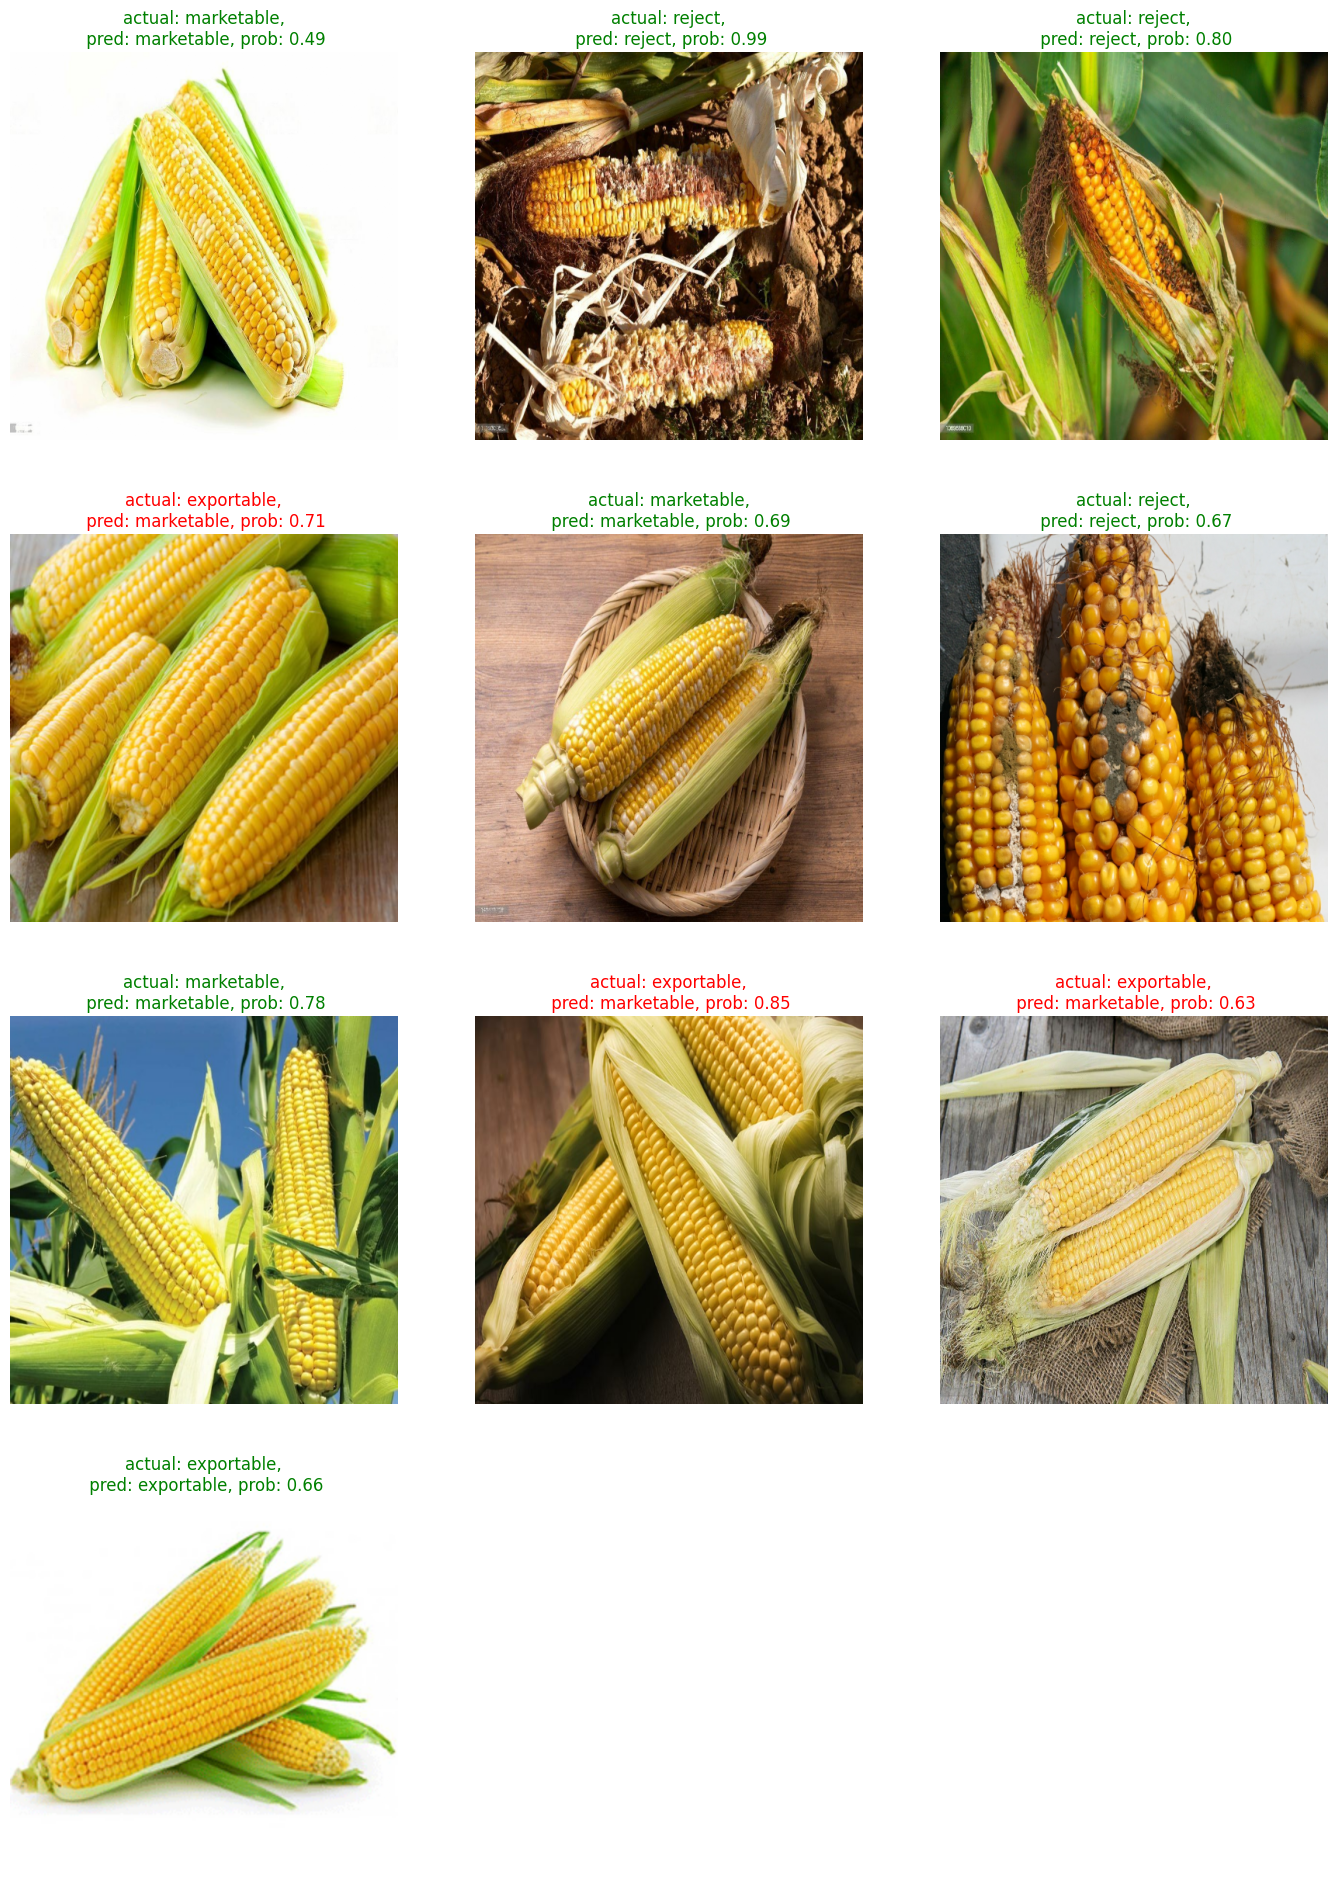

In [43]:
# Make preds on a series of random images
import os
import random
import matplotlib.pyplot as plt

display = 10
row = int(tf.math.ceil(display / 3))

plt.figure(figsize = (17, 6 * row))

for i in range(display):
  # Choose a random image from a random class 
  class_name = random.choice(CLASS_NAMES)
  filename = random.choice(os.listdir("./resources/Actual/test/" + class_name))
  filepath = "./resources/Actual/test/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, img_shape=500, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = CLASS_NAMES[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(row, 3, i+1)
  plt.imshow(img/255.)
  title_color = "g" if class_name == pred_class else "r"
  plt.title(f"actual: {class_name},\n pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)

In [44]:
from sklearn.metrics import classification_report

try:
  preds_prob = model.predict(test_data)
  _helper.notifications.complete()
except Exception as e:
  print(f"Error {e}")
  _helper.notifications.error()

y_label = [
    labels.numpy().argmax() for images, labels in test_data.unbatch()
]
print(y_label[:10])

pred_classes = preds_prob.argmax(axis = 1)

print(classification_report(
  y_true = y_label,
  y_pred = pred_classes
))
classification_report_dict = classification_report(
  y_label,
  pred_classes,
  output_dict = True
)
classification_report_dict["0"]

3/3 [==============================] - 21s 6s/step
[2, 2, 0, 1, 1, 1, 0, 1, 0, 1]
              precision    recall  f1-score   support

           0       0.35      0.20      0.26        30
           1       0.37      0.60      0.46        30
           2       0.38      0.30      0.33        30

    accuracy                           0.37        90
   macro avg       0.37      0.37      0.35        90
weighted avg       0.37      0.37      0.35        90



{'precision': 0.35294117647058826,
 'recall': 0.2,
 'f1-score': 0.25531914893617025,
 'support': 30}

In [ ]:
import pandas as pd
class_f1_score = {}
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_score[CLASS_NAMES[int(k)]] = v["f1-score"]
    
class_f1_score_sorted = pd.DataFrame({
  "class_name": list(class_f1_score.keys()),
  "f1-score": list(class_f1_score.values())
}).sort_values("f1-score", ascending = True)
class_f1_score_sorted

,class_name,f1-score
0,exportable,0.269231
1,marketable,0.361111
2,reject,0.392857


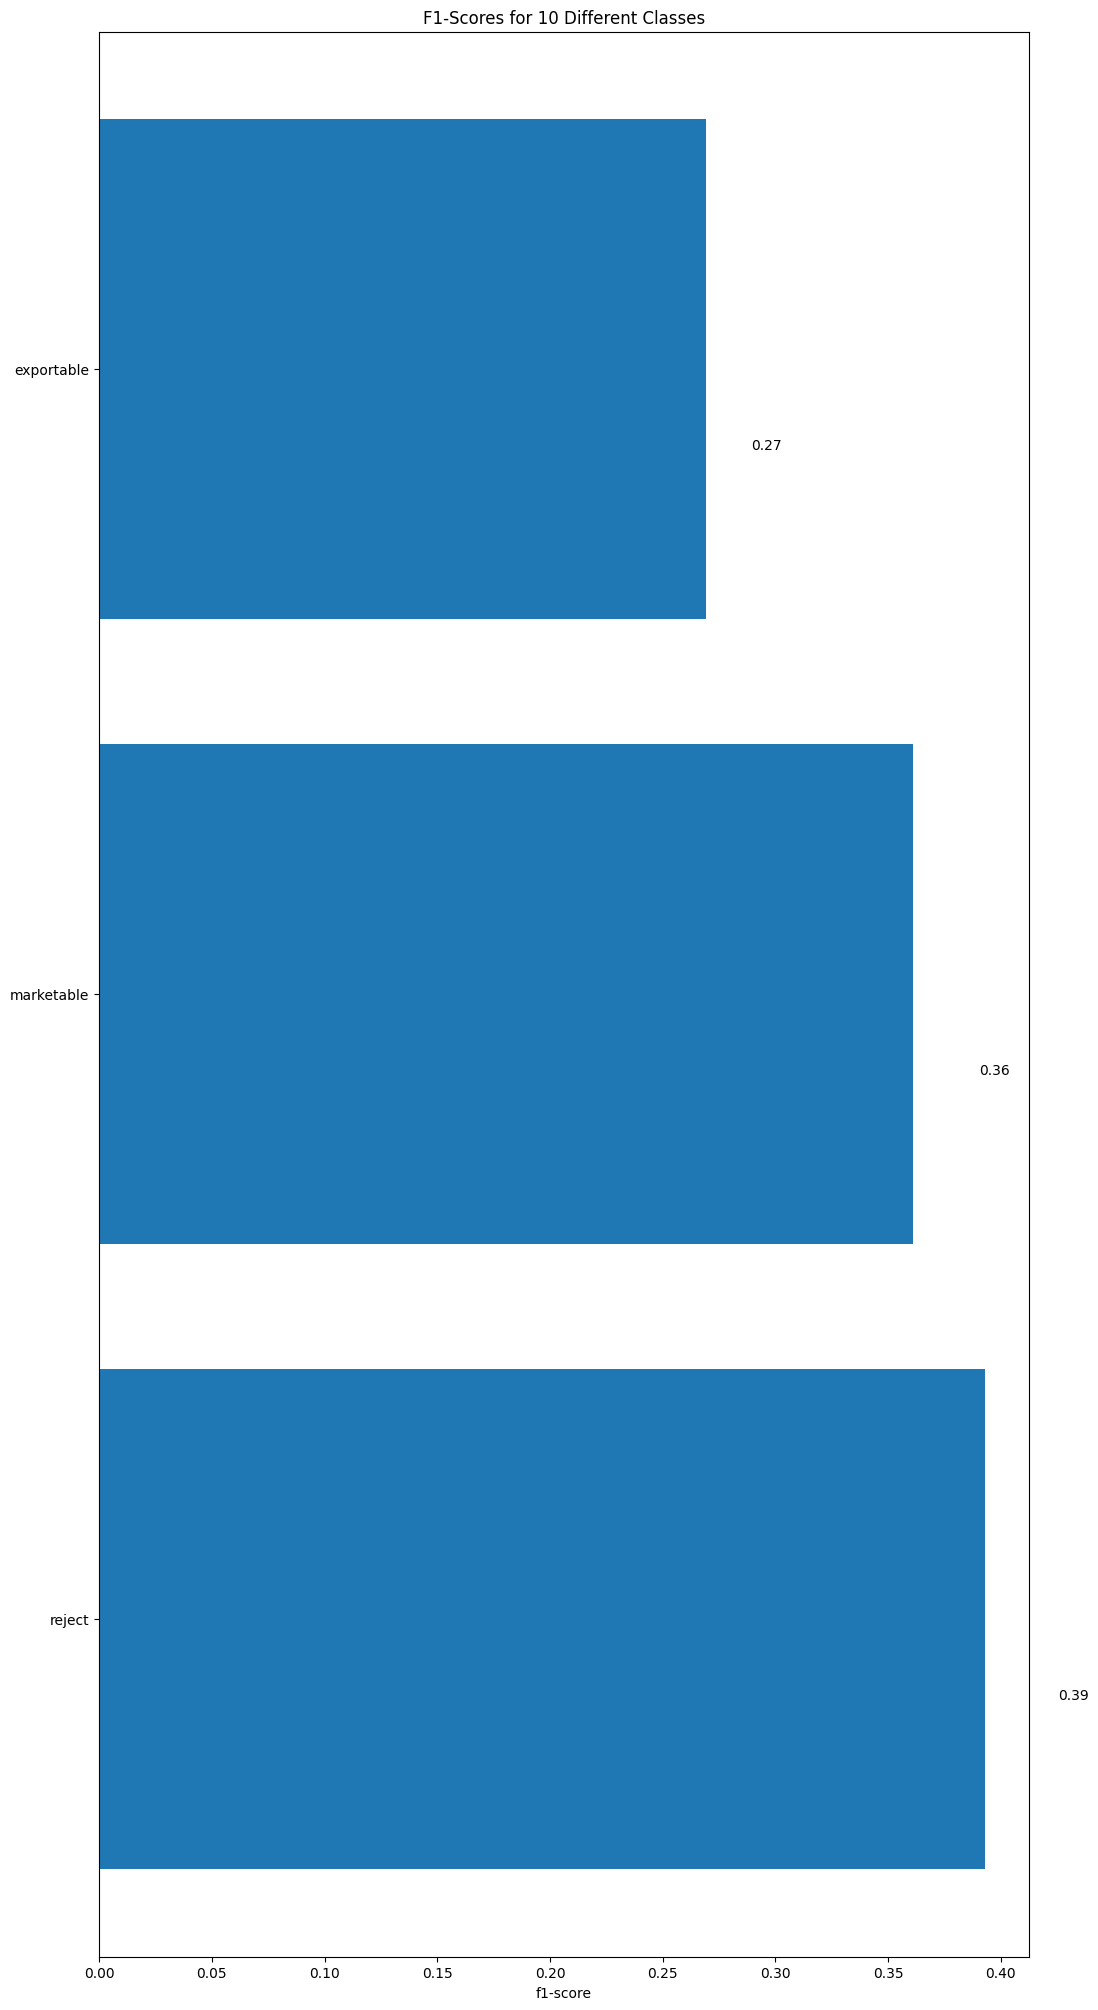

In [45]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(class_f1_score_sorted)), class_f1_score_sorted["f1-score"].values)
ax.set_yticks(range(len(class_f1_score_sorted)))
ax.set_yticklabels(list(class_f1_score_sorted["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.1 * width, rect.get_y() + rect.get_height() / 1.5,
            f"{width:.2f}",
            ha = 'center', va = 'bottom')

autolabel(scores)

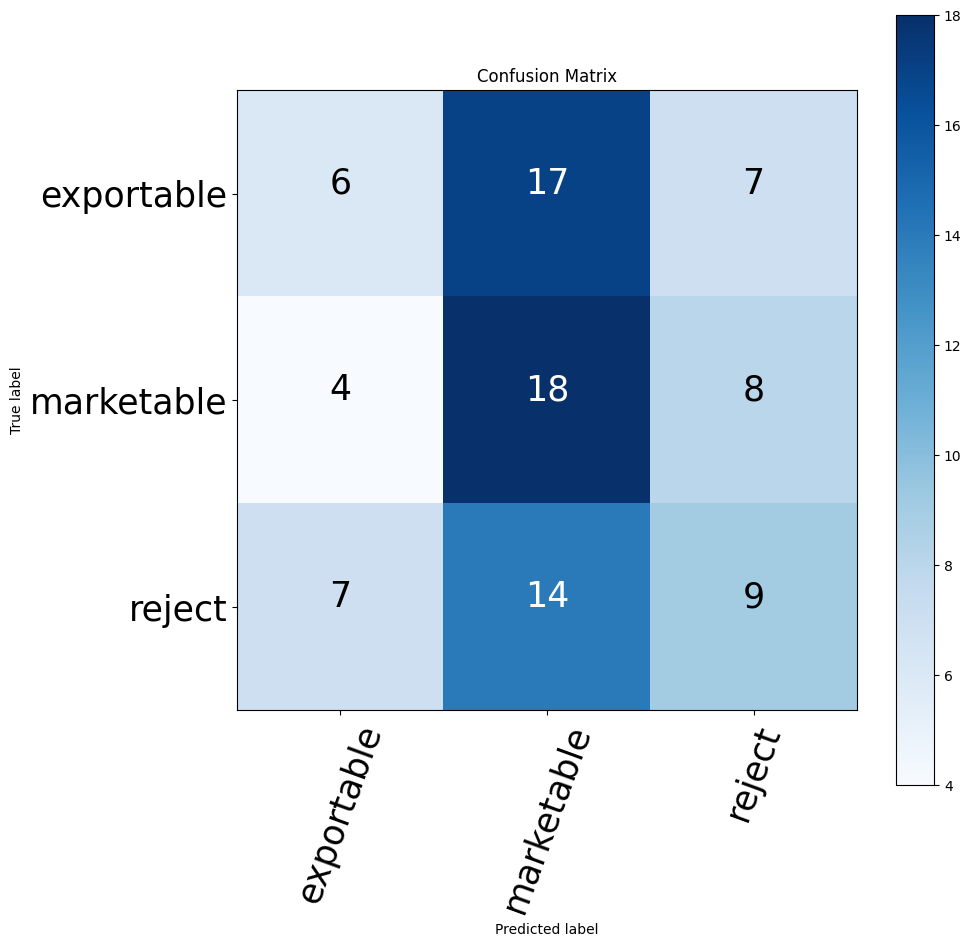

In [46]:
try:
  _helper.evaluation.make_confusion_matrix(y_label, pred_classes, CLASS_NAMES,
                        figsize = (10, 10),
                        text_size = 25)
except Exception as e:
  print(f"error: {e}")
  _helper.notifications.error()

In [18]:
from sidecar import Sidecar
import numpy as np
from ipywebrtc import WidgetStream, VideoRecorder
u = np.linspace(-10, 10, 25)
x, y = np.meshgrid(u, u)
r = np.sqrt(x**2+y**2)
x = x.flatten()
y = y.flatten()
r = r.flatten()
time = np.linspace(0, np.pi*2, 15)
z = np.array([(np.cos(r + t) * np.exp(-r/5)) for t in time])
color = np.array([[np.cos(r + t), 1-np.abs(z[i]), 0.1+z[i]*0] for i, t in enumerate(time)])
size = (z+1)
color = np.transpose(color, (0, 2, 1))